In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
import datetime as dt
from merge_data_barpa import load_stn_info
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.dates as mdates
import tqdm
import warnings

#For plotting soundings
from sharppy.sharptab import winds, utils, params, thermo, interp, profile
from metpy.calc import dewpoint_from_relative_humidity, dewpoint_from_specific_humidity
import glob
from matplotlib import gridspec
from matplotlib.ticker import ScalarFormatter, MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes as inset
from matplotlib.patches import Circle
import sharppy.plot.skew as skew
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [51]:
def plot_sounding_barpa(time, lat, lon):

    barpa_str1 = time.strftime("%Y%m%d")
    barpa_str2 = (time - dt.timedelta(days=5)).strftime("%Y%m%d")    
    
    str_fmt = "/g/data/tp28/BARPA/trials/BARPA-EASTAUS_12km/era/erai/historical/r0/*/%s*/%s/%s*.nc"
    # str_fmt = "/g/data/rt52/era5/pressure-levels/reanalysis/%s/%d/%s_era5_oper_pl_%s*.nc" 
    # str_fmt_sfc = "/g/data/rt52/era5/single-levels/reanalysis/%s/%d/%s_era5_oper_sfc_%s*.nc"
    
    z=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp2","geop_ht_uv")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp2","geop_ht_uv")))),
                        engine="netcdf4")["geop_ht_uv"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")
    t=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp2","air_temp")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp2","air_temp")))),
                        engine="netcdf4")["air_temp_uv"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")    
    s=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp2","spec_hum")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp2","spec_hum")))),
                        engine="netcdf4")["spec_hum_uv"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")    
    u=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp2","wnd_ucmp")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp2","wnd_ucmp")))),
                        engine="netcdf4")["wnd_ucmp_uv"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")    
    v=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp2","wnd_vcmp")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp2","wnd_vcmp")))),
                        engine="netcdf4")["wnd_vcmp_uv"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")

    ts=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp3","temp_scrn")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp3","temp_scrn")))),
                        engine="netcdf4")["temp_scrn"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")    
    dps=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp26","dewpt_scrn")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp26","dewpt_scrn")))),
                        engine="netcdf4")["dewpt_scrn"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")    
    us=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp3","uwnd10m_b")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp3","uwnd10m_b")))),
                        engine="netcdf4")["uwnd10m_b"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")    
    vs=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp3","uwnd10m_b")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp3","uwnd10m_b")))),
                        engine="netcdf4")["uwnd10m_b"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")      
    ps=xr.open_mfdataset(list(np.unique(glob.glob(str_fmt % (barpa_str1[0:6],"pp26","sfc_pres")) + glob.glob(str_fmt % (barpa_str2[0:6],"pp26","sfc_pres")))),
                        engine="netcdf4")["sfc_pres"].\
                        sel({"time":time},method="nearest").interp({"longitude":lon, "latitude":lat},method="nearest")     
    zs=xr.open_dataset("/g/data/tp28/BARPA/trials/BARPA-EASTAUS_12km/static/topog-BARPA-EASTAUS_12km.nc").\
                        interp({"longitude":lon, "latitude":lat},method="nearest")["topog"]

    p=z.pressure
    dp=dewpoint_from_specific_humidity(p,t,s)
    prof_pres = np.flip(p.values.squeeze())
    prof_hgt = np.flip(z.values.squeeze())
    prof_tmpc = np.flip(t.values.squeeze()-273.15)
    prof_dwpc = np.flip(np.array(dp).squeeze())
    prof_u = np.flip(u.values.squeeze()*1.94)
    prof_v = np.flip(v.values.squeeze()*1.94)
    agl_inds = prof_pres <= (ps.values/100.)
    prof = profile.create_profile(pres=np.insert(prof_pres[agl_inds], 0, ps.values/100.),
                                  hght=np.insert(prof_hgt[agl_inds], 0, zs.values),
                                  tmpc=np.insert(prof_tmpc[agl_inds], 0, ts.values-273.15),
                                  dwpc=np.insert(prof_dwpc[agl_inds], 0, dps.values-273.15),
                                  u=np.insert(prof_u[agl_inds], 0, us.values*1.94),
                              v=np.insert(prof_v[agl_inds], 0, vs.values*1.94))
    sfcpcl = params.parcelx( prof, flag=1 )
    mupcl = params.parcelx( prof, flag=3 )
    mlpcl = params.parcelx( prof, flag=4 )   
    return prof, mupcl

def plot_sounding_era5(time, lat, lon):

    str_fmt = "/g/data/rt52/era5/pressure-levels/reanalysis/%s/%d/%s_era5_oper_pl_%s*.nc" 
    str_fmt_sfc = "/g/data/rt52/era5/single-levels/reanalysis/%s/%d/%s_era5_oper_sfc_%s*.nc"
    
    z=xr.open_dataset(glob.glob(str_fmt % ("z",time.year,"z",time.strftime("%Y%m01")))[0])["z"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    t=xr.open_dataset(glob.glob(str_fmt % ("t",time.year,"t",time.strftime("%Y%m01")))[0])["t"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    r=xr.open_dataset(glob.glob(str_fmt % ("r",time.year,"r",time.strftime("%Y%m01")))[0])["r"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    u=xr.open_dataset(glob.glob(str_fmt % ("u",time.year,"u",time.strftime("%Y%m01")))[0])["u"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")
    v=xr.open_dataset(glob.glob(str_fmt % ("v",time.year,"v",time.strftime("%Y%m01")))[0])["v"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")

    ts=xr.open_dataset(glob.glob(str_fmt_sfc % ("2t",time.year,"2t",time.strftime("%Y%m01")))[0])["t2m"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    dps=xr.open_dataset(glob.glob(str_fmt_sfc % ("2d",time.year,"2d",time.strftime("%Y%m01")))[0])["d2m"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    us=xr.open_dataset(glob.glob(str_fmt_sfc % ("10u",time.year,"10u",time.strftime("%Y%m01")))[0])["u10"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    vs=xr.open_dataset(glob.glob(str_fmt_sfc % ("10v",time.year,"10v",time.strftime("%Y%m01")))[0])["v10"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    ps=xr.open_dataset(glob.glob(str_fmt_sfc % ("sp",time.year,"sp",time.strftime("%Y%m01")))[0])["sp"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")    
    zs=xr.open_dataset(glob.glob(str_fmt_sfc % ("z",time.year,"z",time.strftime("%Y%m01")))[0])["z"].\
            sel({"time":time.replace(minute=0)}).interp({"longitude":lon, "latitude":lat},method="nearest")   
    
    p=z.level
    dp=dewpoint_from_relative_humidity(t,r)
    prof_pres = np.flip(p.values.squeeze())
    prof_hgt = np.flip(z.values.squeeze()/9.8)
    prof_tmpc = np.flip(t.values.squeeze()-273.15)
    prof_dwpc = np.flip(np.array(dp).squeeze())
    prof_u = np.flip(u.values.squeeze()*1.94)
    prof_v = np.flip(v.values.squeeze()*1.94)
    agl_inds = prof_pres <= (ps.values/100.)
    prof = profile.create_profile(pres=np.insert(prof_pres[agl_inds], 0, ps.values/100.),
                                  hght=np.insert(prof_hgt[agl_inds], 0, zs.values/9.8),
                                  tmpc=np.insert(prof_tmpc[agl_inds], 0, ts.values-273.15),
                                  dwpc=np.insert(prof_dwpc[agl_inds], 0, dps.values-273.15),
                                  u=np.insert(prof_u[agl_inds], 0, us.values*1.94),
                                  v=np.insert(prof_v[agl_inds], 0, vs.values*1.94))
    sfcpcl = params.parcelx( prof, flag=1 )
    mupcl = params.parcelx( prof, flag=3 )
    mlpcl = params.parcelx( prof, flag=4 )    

    return prof, mupcl

In [3]:
#Read daily maximum wind gusts at each station, created by resample_daily_max.py

dmax_2p2km_point = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_2p2km.csv")
dmax_12km_point = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_12km.csv")
dmax_obs = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_obs.csv")
dmax_bdsd = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_bdsd.csv")
dmax_erai = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_aws_dmax_erai.csv")

#Calculate another ratio, the gust to deep-layer mean
dmax_2p2km_point["dlm_ratio"] = dmax_2p2km_point["wg10_2p2km_point"] / dmax_2p2km_point["Umean06"]
dmax_12km_point["dlm_ratio"] = dmax_12km_point["wg10_12km_point"] / dmax_12km_point["Umean06"]
dmax_obs["dlm_ratio"] = dmax_obs["gust"] / dmax_obs["Umean06_era5"]

dmax_2p2km_point = dmax_2p2km_point.set_index(pd.to_datetime(dmax_2p2km_point.time))
dmax_12km_point = dmax_12km_point.set_index(pd.to_datetime(dmax_12km_point.time))
dmax_obs = dmax_obs.set_index(pd.to_datetime(dmax_obs.time))
dmax_bdsd = dmax_bdsd.set_index(pd.to_datetime(dmax_bdsd.time))

In [4]:
#Suspect gusts to drop - observations
obs_times = pd.to_datetime(dmax_obs.time)
dmax_obs.loc[(obs_times.dt.month == 12) & (obs_times.dt.year == 2010) & (dmax_obs.stn_id==55325) & (dmax_obs.gust >= 25),"gust"] = np.nan
dmax_obs.loc[dmax_obs.gust>=129, "gust"] = np.nan 


In [5]:
#Take the domain maximum for each day
dmax_2p2km_all = dmax_2p2km_point.sort_values("wg10_2p2km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_12km_all = dmax_12km_point.sort_values("wg10_12km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_obs_all = dmax_obs.dropna(subset=["gust"]).sort_values("gust").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_bdsd_all = dmax_bdsd.sort_values("bdsd_era5").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_erai_all = dmax_erai.sort_values("erai_wg10").drop_duplicates("dt_floor_1D",keep="last").sort_index()

In [6]:
#Take the domain maximum for each day using daily maximum observations at each station with lightning
dmax_2p2km_conv = dmax_2p2km_point.query("n_lightning_fl>=1").sort_values("wg10_2p2km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_12km_conv = dmax_12km_point.query("n_lightning_fl>=1").sort_values("wg10_12km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_obs_conv = dmax_obs.query("Lightning_observed_daily>=1").dropna(subset=["gust"]).sort_values("gust").drop_duplicates("dt_floor_1D",keep="last").sort_index()

#Take the domain maximum for each day using daily maximum observations at each station without lightning
dmax_2p2km_nonconv = dmax_2p2km_point.query("n_lightning_fl==0").sort_values("wg10_2p2km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_12km_nonconv = dmax_12km_point.query("n_lightning_fl==0").sort_values("wg10_12km_point").drop_duplicates("dt_floor_1D",keep="last").sort_index()
dmax_obs_nonconv = dmax_obs.query("Lightning_observed_daily==0").dropna(subset=["gust"]).sort_values("gust").drop_duplicates("dt_floor_1D",keep="last").sort_index()


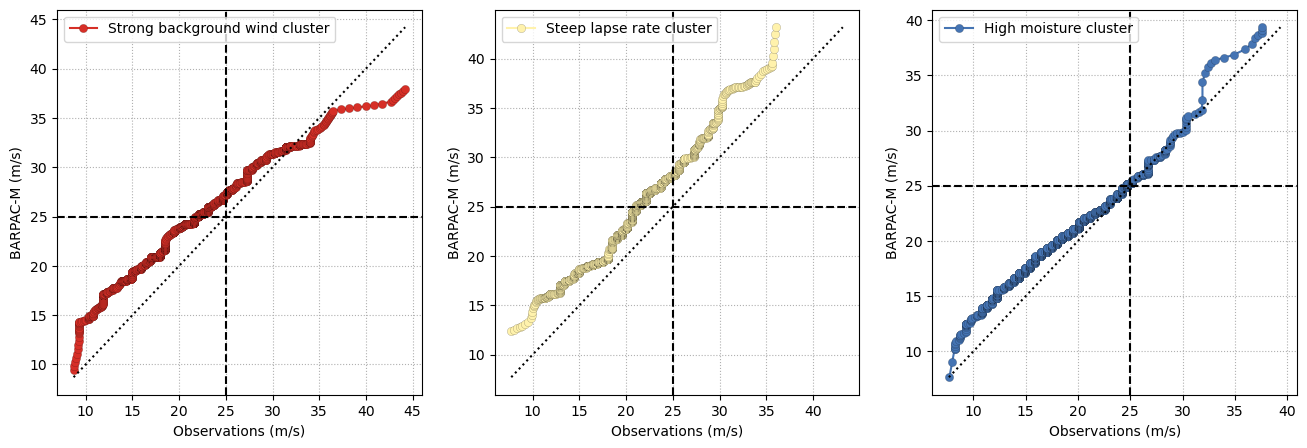

In [9]:
def plot_qq(df1,col1,df2,col2,label="",p=1000,color="tab:blue"):

    values1 = df1[col1].values
    values2 = df2[col2].values
    plt.plot(np.percentile(values1,np.linspace(0,100,p)),np.percentile(values2,np.linspace(0,100,p)),label=label,marker="o",color=color,mec="k",mew=0.1)
    plt.plot([np.min([values1.min(),values2.min()]),np.max([values1.max(),values2.max()])],
             [np.min([values1.min(),values2.min()]),np.max([values1.max(),values2.max()])],color="k",ls=":")
    plt.gca().grid(ls=":")
    plt.legend()

plt.figure(figsize=[16,5])

plt.subplot(1,3,1)
plot_qq(dmax_obs_conv.query("cluster_era5==1"),"gust",dmax_2p2km_conv.query("cluster==1"),"wg10_2p2km_point",color=plt.get_cmap("RdYlBu")(0.1),label="Strong background wind cluster")
plt.xlabel("Observations (m/s)")
plt.ylabel("BARPAC-M (m/s)")
plt.gca().axhline(25,ls="--",color="k")
plt.gca().axvline(25,ls="--",color="k")

plt.subplot(1,3,2)
plot_qq(dmax_obs_conv.query("cluster_era5==2"),"gust",dmax_2p2km_conv.query("cluster==2"),"wg10_2p2km_point",color=plt.get_cmap("RdYlBu")(0.46),label="Steep lapse rate cluster")
plt.xlabel("Observations (m/s)")
plt.ylabel("BARPAC-M (m/s)")
plt.gca().axhline(25,ls="--",color="k")
plt.gca().axvline(25,ls="--",color="k")

plt.subplot(1,3,3)
plot_qq(dmax_obs_conv.query("cluster_era5==0"),"gust",dmax_2p2km_conv.query("cluster==0"),"wg10_2p2km_point",color=plt.get_cmap("RdYlBu")(0.9),label="High moisture cluster")
plt.xlabel("Observations (m/s)")
plt.ylabel("BARPAC-M (m/s)")
plt.gca().axhline(25,ls="--",color="k")
plt.gca().axvline(25,ls="--",color="k")

## Investigate why there is a strong positive bias by looking at vertical profiles for convective daily-domain maximum gusts in each cluster

In [39]:
#Steep lapse rate cluster
slr_events_barpa = dmax_2p2km_conv[dmax_2p2km_conv.cluster==2][["time","stn_id","state"]]
profs = []
mu_pcl = []
warnings.simplefilter("ignore")
for name, row in tqdm.tqdm(slr_events_barpa.iterrows()):
    lat,lon=load_stn_info(row.state).query("stn_no=="+str(row.stn_id))[["lat","lon"]].values[0]
    try:
        temp_prof, temp_mu_pcl = plot_sounding_barpa(
            pd.to_datetime(row.time).floor("6H"),lat,lon)
        profs.append(temp_prof)
        mu_pcl.append(temp_mu_pcl)        
    except:
        print("COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR ",row)


16it [00:33,  1.56s/it]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2005-12-23 05:30:00
stn_id                  87113
state                     vic
Name: 2005-12-23 05:30:00, dtype: object


21it [00:51,  3.48s/it]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2006-01-01 08:50:00
stn_id                  68228
state                     nsw
Name: 2006-01-01 08:50:00, dtype: object


34it [01:36,  4.34s/it]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2006-12-10 05:20:00
stn_id                  86398
state                     vic
Name: 2006-12-10 05:20:00, dtype: object


60it [03:16,  3.83s/it]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2008-12-17 06:40:00
stn_id                  76031
state                     vic
Name: 2008-12-17 06:40:00, dtype: object


69it [03:42,  2.95s/it]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2009-01-24 06:50:00
stn_id                  68228
state                     nsw
Name: 2009-01-24 06:50:00, dtype: object


75it [03:57,  2.18s/it]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2009-12-03 09:40:00
stn_id                  88164
state                     vic
Name: 2009-12-03 09:40:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2009-12-08 08:00:00
stn_id                  61366
state                     nsw
Name: 2009-12-08 08:00:00, dtype: object


77it [03:57,  1.23s/it]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2009-12-10 06:20:00
stn_id                  85280
state                     vic
Name: 2009-12-10 06:20:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2009-12-16 22:50:00
stn_id                  70217
state                     nsw
Name: 2009-12-16 22:50:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2009-12-17 04:30:00
stn_id                  70339
state                     nsw
Name: 2009-12-17 04:30:00, dtype: object


81it [03:57,  1.87it/s]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2009-12-18 07:00:00
stn_id                  53115
state                     nsw
Name: 2009-12-18 07:00:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2009-12-22 10:20:00
stn_id                  66059
state                     nsw
Name: 2009-12-22 10:20:00, dtype: object


83it [03:58,  2.59it/s]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2009-12-23 08:00:00
stn_id                  23842
state                      sa
Name: 2009-12-23 08:00:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2009-12-24 07:10:00
stn_id                  70014
state                     nsw
Name: 2009-12-24 07:10:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2009-12-30 23:50:00
stn_id                  87168
state                     vic
Name: 2009-12-30 23:50:00, dtype: object


112it [05:38,  3.55s/it]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2012-01-01 21:00:00
stn_id                  86397
state                     vic
Name: 2012-01-01 21:00:00, dtype: object


128it [06:13,  1.04s/it]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2012-12-07 23:30:00
stn_id                  18201
state                      sa
Name: 2012-12-07 23:30:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2012-12-08 03:30:00
stn_id                  97080
state                     tas
Name: 2012-12-08 03:30:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2012-12-11 07:00:00
stn_id                  46129
state                     nsw
Name: 2012-12-11 07:00:00, dtype: object


130it [06:13,  1.52it/s]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2012-12-12 07:20:00
stn_id                  20062
state                      sa
Name: 2012-12-12 07:20:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2012-12-13 03:40:00
stn_id                  87166
state                     vic
Name: 2012-12-13 03:40:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2012-12-14 21:40:00
stn_id                  49000
state                     nsw
Name: 2012-12-14 21:40:00, dtype: object


134it [06:14,  3.07it/s]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2012-12-18 23:50:00
stn_id                  87168
state                     vic
Name: 2012-12-18 23:50:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2012-12-19 05:20:00
stn_id                  80128
state                     vic
Name: 2012-12-19 05:20:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2012-12-24 09:20:00
stn_id                  65103
state                     nsw
Name: 2012-12-24 09:20:00, dtype: object


137it [06:15,  3.38it/s]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2013-01-06 06:30:00
stn_id                  72150
state                     nsw
Name: 2013-01-06 06:30:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2013-01-08 21:20:00
stn_id                  46126
state                     nsw
Name: 2013-01-08 21:20:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2013-01-09 06:50:00
stn_id                  58012
state                     nsw
Name: 2013-01-09 06:50:00, dtype: object


139it [06:15,  4.46it/s]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2013-01-11 01:00:00
stn_id                  83090
state                     vic
Name: 2013-01-11 01:00:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2013-01-18 09:10:00
stn_id                  66043
state                     nsw
Name: 2013-01-18 09:10:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2013-01-25 06:10:00
stn_id                  88109
state                     vic
Name: 2013-01-25 06:10:00, dtype: object


141it [06:15,  5.67it/s]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2013-01-31 08:00:00
stn_id                  83090
state                     vic
Name: 2013-01-31 08:00:00, dtype: object


143it [06:16,  4.37it/s]

COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2013-02-08 06:10:00
stn_id                  20062
state                      sa
Name: 2013-02-08 06:10:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2013-02-09 06:00:00
stn_id                  83090
state                     vic
Name: 2013-02-09 06:00:00, dtype: object
COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR  time      2013-02-10 05:30:00
stn_id                  73138
state                     nsw
Name: 2013-02-10 05:30:00, dtype: object


192it [08:49,  2.76s/it]


In [52]:
#Steep lapse rate cluster
slr_events_obs = dmax_obs_conv[dmax_obs_conv.cluster_era5==2][["time","stn_id","state"]]
profs_obs = []
mu_pcl_obs = []
print(slr_events_obs.shape)
warnings.simplefilter("ignore")
for name, row in tqdm.tqdm(slr_events_obs.iterrows()):
    lat,lon=load_stn_info(row.state).query("stn_no=="+str(row.stn_id))[["lat","lon"]].values[0]
    try:
        temp_prof, temp_mu_pcl = plot_sounding_era5(
            pd.to_datetime(row.time).floor("6H"),lat,lon)
        profs_obs.append(temp_prof)
        mu_pcl_obs.append(temp_mu_pcl)        
    except:
        print("COULD NOT GET SOUNDING. PROBLEM WITH DATA FOR ",row)


(144, 3)


144it [10:47,  4.49s/it]


<AxesSubplot:>

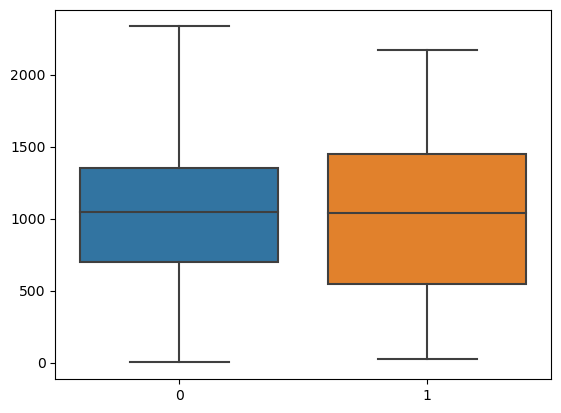

In [56]:
sns.boxplot(data=[[params.dcape(p)[0] for p in profs], [params.dcape(p)[0] for p in profs_obs]])